In [2]:
import asf_search as asf
import geopandas as gpd
import numpy as np
import pandas as pd
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import requests

In [4]:
footprint = geojson_to_wkt(read_geojson("../../data/poznan.geojson"))
date_start = "2022/05/01"
date_end = "2022/10/01"

In [5]:
products = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                          intersectsWith=footprint,
                          processingLevel=[asf.PRODUCT_TYPE.SLC],
                          start=date_start,
                          end=date_end,
                          maxResults=10)
products_df = pd.DataFrame([p.properties for p in products])
products_df

,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,flightDirection,groupID,granuleType,...,processingDate,processingLevel,sceneName,sensor,startTime,stopTime,url,pgeVersion,fileName,frameNumber
0,IW,None,4657751122,52.2492,17.9661,None,S1A_IW_SLC__1SDV_20220929T163603_20220929T1636...,ASCENDING,S1A_IWDV_0167_0173_045222_175,SENTINEL_1A_FRAME,...,2022-09-29T16:36:03.000Z,SLC,S1A_IW_SLC__1SDV_20220929T163603_20220929T1636...,C-SAR,2022-09-29T16:36:03.000Z,2022-09-29T16:36:30.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220929T163603_20220929T1636...,167
1,IW,None,4580763215,52.6218,18.4544,None,S1A_IW_SLC__1SDV_20220926T050057_20220926T0501...,DESCENDING,S1A_IWDV_0416_0423_045171_124,SENTINEL_1A_FRAME,...,2022-09-26T05:00:57.000Z,SLC,S1A_IW_SLC__1SDV_20220926T050057_20220926T0501...,C-SAR,2022-09-26T05:00:57.000Z,2022-09-26T05:01:24.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220926T050057_20220926T0501...,417
2,IW,None,4609579705,53.0143,15.6840,None,S1A_IW_SLC__1SDV_20220922T164428_20220922T1644...,ASCENDING,S1A_IWDV_0169_0176_045120_073,SENTINEL_1A_FRAME,...,2022-09-22T16:44:28.000Z,SLC,S1A_IW_SLC__1SDV_20220922T164428_20220922T1644...,C-SAR,2022-09-22T16:44:28.000Z,2022-09-22T16:44:56.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220922T164428_20220922T1644...,170
3,IW,None,4646654586,51.5302,16.1188,None,S1A_IW_SLC__1SDV_20220922T164404_20220922T1644...,ASCENDING,S1A_IWDV_0165_0170_045120_073,SENTINEL_1A_FRAME,...,2022-09-22T16:44:04.000Z,SLC,S1A_IW_SLC__1SDV_20220922T164404_20220922T1644...,C-SAR,2022-09-22T16:44:04.000Z,2022-09-22T16:44:31.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220922T164404_20220922T1644...,165
4,IW,None,4686861613,53.0102,16.5167,None,S1A_IW_SLC__1SDV_20220919T050904_20220919T0509...,DESCENDING,S1A_IWDV_0415_0421_045069_022,SENTINEL_1A_FRAME,...,2022-09-19T05:09:04.000Z,SLC,S1A_IW_SLC__1SDV_20220919T050904_20220919T0509...,C-SAR,2022-09-19T05:09:04.000Z,2022-09-19T05:09:31.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220919T050904_20220919T0509...,415
5,IW,None,4652270299,52.2492,17.9662,None,S1A_IW_SLC__1SDV_20220917T163602_20220917T1636...,ASCENDING,S1A_IWDV_0167_0173_045047_175,SENTINEL_1A_FRAME,...,2022-09-17T16:36:02.000Z,SLC,S1A_IW_SLC__1SDV_20220917T163602_20220917T1636...,C-SAR,2022-09-17T16:36:02.000Z,2022-09-17T16:36:30.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220917T163602_20220917T1636...,167
6,IW,None,4734573721,52.6220,18.4523,None,S1A_IW_SLC__1SDV_20220914T050057_20220914T0501...,DESCENDING,S1A_IWDV_0416_0423_044996_124,SENTINEL_1A_FRAME,...,2022-09-14T05:00:57.000Z,SLC,S1A_IW_SLC__1SDV_20220914T050057_20220914T0501...,C-SAR,2022-09-14T05:00:57.000Z,2022-09-14T05:01:24.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220914T050057_20220914T0501...,417
7,IW,None,4707081403,53.0145,15.6814,None,S1A_IW_SLC__1SDV_20220910T164429_20220910T1644...,ASCENDING,S1A_IWDV_0169_0176_044945_073,SENTINEL_1A_FRAME,...,2022-09-10T16:44:29.000Z,SLC,S1A_IW_SLC__1SDV_20220910T164429_20220910T1644...,C-SAR,2022-09-10T16:44:29.000Z,2022-09-10T16:44:56.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220910T164429_20220910T1644...,170
8,IW,None,4721237800,51.5303,16.1161,None,S1A_IW_SLC__1SDV_20220910T164404_20220910T1644...,ASCENDING,S1A_IWDV_0164_0171_044945_073,SENTINEL_1A_FRAME,...,2022-09-10T16:44:04.000Z,SLC,S1A_IW_SLC__1SDV_20220910T164404_20220910T1644...,C-SAR,2022-09-10T16:44:04.000Z,2022-09-10T16:44:32.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220910T164404_20220910T1644...,165
9,IW,None,4575317676,53.0107,16.5132,None,S1A_IW_SLC__1SDV_20220907T050904_20220907T0509...,DESCENDING,S1A_IWDV_0415_0421_044894_022,SENTINEL_1A_FRAME,...,2022-09-07T05:09:04.000Z,SLC,

In [6]:
# Create empty list to hold the results
candidates = []

# Read scene IDs
# Get ids for filtered images
geo_ids = products_df['fileID'].map(lambda fileID: str.replace(fileID, '-SLC', '')).tolist()
geo_ids

['S1A_IW_SLC__1SDV_20220929T163603_20220929T163630_045222_0567B7_46CF',
 'S1A_IW_SLC__1SDV_20220926T050057_20220926T050124_045171_05661A_0697',
 'S1A_IW_SLC__1SDV_20220922T164428_20220922T164456_045120_05645B_F90A',
 'S1A_IW_SLC__1SDV_20220922T164404_20220922T164431_045120_05645B_FC43',
 'S1A_IW_SLC__1SDV_20220919T050904_20220919T050931_045069_0562AC_9D42',
 'S1A_IW_SLC__1SDV_20220917T163602_20220917T163630_045047_0561E0_9135',
 'S1A_IW_SLC__1SDV_20220914T050057_20220914T050124_044996_056031_849C',
 'S1A_IW_SLC__1SDV_20220910T164429_20220910T164456_044945_055E74_AD7B',
 'S1A_IW_SLC__1SDV_20220910T164404_20220910T164432_044945_055E74_DAF3',
 'S1A_IW_SLC__1SDV_20220907T050904_20220907T050931_044894_055CC3_3067']

In [7]:
order_url = "https://api.daac.asf.alaska.edu/services/search/baseline?reference="
scene_id = geo_ids[0]
output_type = "&output=geojson"
url = order_url + scene_id + output_type
response = requests.post(url)

In [12]:
baselines = response.json()

In [18]:
gdf = gpd.GeoDataFrame.from_features(baselines["features"])

In [28]:
gdf

,geometry,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,fileName,flightDirection,...,pointingAngle,polarization,processingDate,processingLevel,sceneName,sensor,startTime,stopTime,temporalBaseline,url
0,"POLYGON ((19.65282 53.24859, 20.05559 51.62868...",IW,[],4675450333,52.2497,17.9655,None,S1A_IW_SLC__1SDV_20230726T163605_20230726T1636...,S1A_IW_SLC__1SDV_20230726T163605_20230726T1636...,ASCENDING,...,None,VV+VH,2023-07-26T16:36:05.545538Z,SLC,S1A_IW_SLC__1SDV_20230726T163605_20230726T1636...,C-SAR,2023-07-26T16:36:05.545538Z,2023-07-26T16:36:32.627492Z,300,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
1,"POLYGON ((19.65323 53.24876, 20.05595 51.62884...",IW,[],4626122112,52.2499,17.9659,None,S1A_IW_SLC__1SDV_20230714T163604_20230714T1636...,S1A_IW_SLC__1SDV_20230714T163604_20230714T1636...,ASCENDING,...,None,VV+VH,2023-07-14T16:36:04.988284Z,SLC,S1A_IW_SLC__1SDV_20230714T163604_20230714T1636...,C-SAR,2023-07-14T16:36:04.988284Z,2023-07-14T16:36:32.070238Z,288,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
2,"POLYGON ((19.65534 53.24877, 20.05800 51.62885...",IW,[],4718179946,52.2499,17.968,None,S1A_IW_SLC__1SDV_20230702T163603_20230702T1636...,S1A_IW_SLC__1SDV_20230702T163603_20230702T1636...,ASCENDING,...,None,VV+VH,2023-07-02T16:36:03.964009Z,SLC,S1A_IW_SLC__1SDV_20230702T163603_20230702T1636...,C-SAR,2023-07-02T16:36:03.964009Z,2023-07-02T16:36:31.045963Z,276,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
3,"POLYGON ((19.65565 53.24830, 20.05836 51.62826...",IW,[],4672535887,52.2494,17.9683,None,S1A_IW_SLC__1SDV_20230620T163603_20230620T1636...,S1A_IW_SLC__1SDV_20230620T163603_20230620T1636...,ASCENDING,...,None,VV+VH,2023-06-20T16:36:03.166602Z,SLC,S1A_IW_SLC__1SDV_20230620T163603_20230620T1636...,C-SAR,2023-06-20T16:36:03.166602Z,2023-06-20T16:36:30.250611Z,264,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
4,"POLYGON ((19.65568 53.24764, 20.05846 51.62760...",IW,[],4602288428,52.2487,17.9684,None,S1A_IW_SLC__1SDV_20230608T163602_20230608T1636...,S1A_IW_SLC__1SDV_20230608T163602_20230608T1636...,ASCENDING,...,None,VV+VH,2023-06-08T16:36:02.000000,SLC,S1A_IW_SLC__1SDV_20230608T163602_20230608T1636...,C-SAR,2023-06-08T16:36:02.000000,2023-06-08T16:36:29.000000,252,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,"POLYGON ((19.52504 53.57445, 19.93220 51.95523...",IW,[],4486483588,52.5775,17.8488,None,S1A_IW_SLC__1SDV_20141228T163517_20141228T1635...,S1A_IW_SLC__1SDV_20141228T163517_20141228T1635...,ASCENDING,...,None,VV+VH,2014-12-28T16:35:17.000000,SLC,S1A_IW_SLC__1SDV_20141228T163517_20141228T1635...,C-SAR,2014-12-28T16:35:17.000000,2014-12-28T16:35:44.000000,-2832,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
440,"POLYGON ((19.52498 53.57462, 19.93212 51.95540...",IW,[],4728062249,52.5777,17.8487,None,S1A_IW_SLC__1SDV_20141216T163518_20141216T1635...,S1A_IW_SLC__1SDV_20141216T163518_20141216T1635...,ASCENDING,...,None,VV+VH,2014-12-16T16:35:18.000000,SLC,S1A_IW_SLC__1SDV_20141216T163518_20141216T1635...,C-SAR,2014-12-16T16:35:18.000000,2014-12-16T16:35:45.000000,-2844,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
441,"POLYGON ((19.52732 53.57420, 19.93431 51.95522...",IW,[],4522111160,52.5774,17.8509,None,S1A_IW_SLC__1SDV_20141204T163518_20141204T1635...,S1A_IW_SLC__1SDV_20141204T163518_20141204T1635...,ASCENDING,...,None,VV+VH,2014-12-04T16:35:18.000000,SLC,S1A_IW_SLC__1SDV_20141204T163518_20141204T1635...,C-SAR,2014-12-04T16:35:18.000000,2014-12-04T16:35:45.000000,-2856,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...
442,"POLYGON ((19.52701 53.57429, 19.93403 51.95506...",IW,[],4722951640,52.5774,17.8506,None,S1A_IW_SLC__1SDV_20141122T163518_20141122T1635...,S1A_IW_SLC__1SDV_20141122T163518_20141122T1635...,ASCENDING,...,None,VV+VH,2014-11-22T16:35:18.000000,SLC,S1A_IW_SLC__1SDV_20141122T163518_20141122T1635...,C-SAR,2014-11-22T16:35:18.000000,2014-11-22T16:35:46.000000,-2868,http

In [38]:
gdf.columns.tolist()

['geometry',
 'beamModeType',
 'browse',
 'bytes',
 'centerLat',
 'centerLon',
 'faradayRotation',
 'fileID',
 'fileName',
 'flightDirection',
 'frameNumber',
 'granuleType',
 'groupID',
 'insarStackId',
 'md5sum',
 'offNadirAngle',
 'orbit',
 'pathNumber',
 'perpendicularBaseline',
 'platform',
 'pointingAngle',
 'polarization',
 'processingDate',
 'processingLevel',
 'sceneName',
 'sensor',
 'startTime',
 'stopTime',
 'temporalBaseline',
 'url']

<Axes: xlabel='temporalBaseline', ylabel='perpendicularBaseline'>

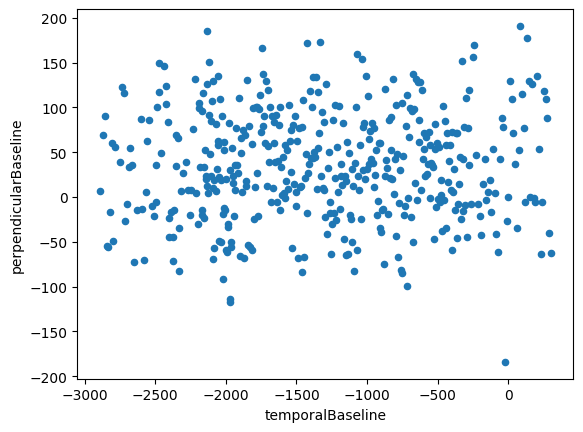

In [61]:
gdf.plot.scatter(x="temporalBaseline", y="perpendicularBaseline")

In [1]:
gdf.explore(column="perpendicularBaseline", style_kwds=dict(opacity=0.1, fillOpacity=0.1))

NameError: name 'gdf' is not defined

Flood mapping example: https://crisjosil.github.io/posts/2020/10/blog-post-4/

Check `xsar` and `pyroSAR`

In [6]:
api_url='https://planetarycomputer.microsoft.com/api/stac/v1'

In [7]:
import pystac_client
client = pystac_client.Client.open(api_url)

In [8]:
for collection in catalog.get_collections():
    print(collection)

<CollectionClient id=daymet-annual-pr>
<CollectionClient id=daymet-daily-hi>
<CollectionClient id=3dep-seamless>
<CollectionClient id=3dep-lidar-dsm>
<CollectionClient id=fia>
<CollectionClient id=sentinel-1-rtc>
<CollectionClient id=gridmet>
<CollectionClient id=daymet-annual-na>
<CollectionClient id=daymet-monthly-na>
<CollectionClient id=daymet-annual-hi>
<CollectionClient id=daymet-monthly-hi>
<CollectionClient id=daymet-monthly-pr>
<CollectionClient id=gnatsgo-tables>
<CollectionClient id=hgb>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=goes-cmi>
<CollectionClient id=terraclimate>
<CollectionClient id=nasa-nex-gddp-cmip6>
<CollectionClient id=gpm-imerg-hhr>
<CollectionClient id=gnatsgo-rasters>
<CollectionClient id=3dep-lidar-hag>
<CollectionClient id=3dep-lidar-intensity>
<CollectionClient id=3dep-lidar-pointsourceid>
<CollectionClient id=mtbs>
<CollectionClient id=noaa-c-cap>
<CollectionClient id=3dep-lidar-copc>
<CollectionClie

In [9]:
# collection ID
collection = 'sentinel-1-grd'
# AMS coordinates
lon = 16.9
lat = 52.4
# date range
datetime = '2022-05-01/2022-10-01'
import shapely
point = shapely.Point(lon, lat)

In [10]:
search = catalog.search(
    collections=[collection],
    intersects=point,
    datetime=datetime
)

In [11]:
items = search.item_collection()

In [12]:
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Found 52 items


In [13]:
item

<Item id=S1A_IW_GRDH_1SDV_20221001T050906_20221001T050931_045244_056888>

Check: https://github.com/eupassarinho/sentinel-1-SAR-vegetation-indices/tree/main and https://github.com/e-marshall/sentinel1_rtc